# 用TensorFlow并行化神经网络训练

主要内容
- Tensorflow如何提升训练性能
- 使用Tensorflow优化机器学习代码
- 使用Tensorflow高层API建立多层神经网络
- 为人工神经网络选择激活函数
- 介绍Keras，一个围绕TensorFlow的高级包装器，用于最方便地实现常见的深度学习架构

## TensorFlow 和训练性能

### TensorFlow第一步

环境如下
```
显卡: GTX 1060
cuda: 10.0
cudnn: for cuda 10.0
```
> 使用cuda 10.1不兼容

In [7]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [3]:
import tensorflow as tf
## create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w*x + b
    init = tf.global_variables_initializer()

with tf.Session(graph=g) as sess:
    # initialize w and b
    sess.run(init)
    # evaluate z
    for t in [1.0, 0.6, -1.8]:
        print('x={:4.1f} --> z={:4.1f}'.format(t, sess.run(z, feed_dict={x:t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [6]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1, 2, 3]}))

[2.7 4.7 6.7]


### 使用数组结构

In [8]:
import tensorflow as tf
import numpy as np

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None, 2, 3), name='input_x')
    x2 = tf.reshape(x, shape=(-1, 6), name='x2')
    # calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    # calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n', sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n', sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n', sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


`tf.reshape(tensor, shape=(-1,)) can be used to flatten a tensor.`

### 用TensorFlow底层API开发一个简单模型

In [11]:
import tensorflow as tf
import numpy as np

X_train = np.arange(10).reshape(10, 1)
y_train = np.array([1, 1.3, 3.1, 2, 5, 6.3, 6.6, 7.4, 8, 9])

In [14]:
class TfLinreg(object):
    
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim=x_dim
        self.learning_rate=learning_rate
        self.g=tf.Graph()
        # build the model
        with self.g.as_default():
            # set graph-level random-seed
            tf.set_random_seed(random_seed)
            self.build()
            # create initializer
            self.init_op = tf.global_variables_initializer()
    
    def build(self):
        # define placeholders for input
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.x_dim), name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None), name='y_input')
        print(self.X)
        print(self.y)
        # define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)), name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), name='bias')
        print(w)
        print(b)
        self.z_net = tf.squeeze(w*self.X + b, name='z_net')
        print(self.z_net)
        sqr_errors = tf.square(self.y - self.z_net, name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate, name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [15]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [16]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    # initialiaze all variables: W and b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
    
    return training_costs

In [17]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

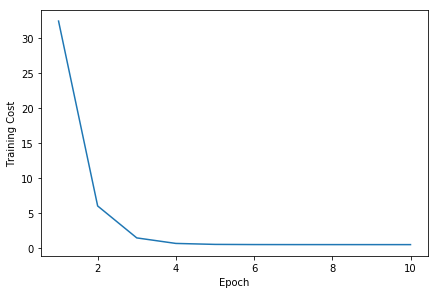

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [20]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net, feed_dict={model.X:X_test})
    return y_pred

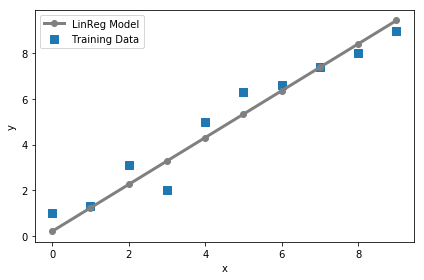

In [21]:
plt.scatter(X_train, y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]), predict_linreg(sess, lrmodel, X_train), color='gray', marker='o', markersize=6, linewidth=3, label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

## 用TensorFlow高层API更有效率的训练神经网络

In [24]:
import os
import struct

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '{}-labels-idx1-ubyte'.format(kind))
    images_path = os.path.join(path, '{}-images-idx3-ubyte'.format(kind))

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [25]:
# loading the data
X_train, y_train = load_mnist('./mnist/', kind='train')
print('Rows: {}, Columns: {}'.format(X_train.shape[0], X_train.shape[1]))

Rows: 60000, Columns: 784


In [26]:
X_test, y_test = load_mnist('./mnist/', kind='t10k')
print('Rows: {}, Columns: {}'.format(X_test.shape[0], X_test.shape[1]))

Rows: 10000, Columns: 784


In [27]:
# mean centering and normalization:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val
del X_train, X_test
print(X_train_centered.shape, y_train.shape)
print(X_test_centered.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)
